# Code to Find Asteroids in an Image

### Preparing Coding Environment by Installing Libraries

In [57]:
### Importing Required Libraries ###
import numpy as np
from astropy.io import fits
import urllib as url
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm
import sys
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astroquery.mpc import MPC
from pprint import pprint
from astroquery.vizier import Vizier 
import astropy.units as u 
import astropy.coordinates as coord



## Step 1: Set Up 

-----------------------------------------------------------------------------------------------------------------------------

### Getting Image and Header from FITS File

In [58]:
### Opening FITS file ###
file = fits.open('apophis1.fits')
image = file[0]

header = image.header #Getting File Header


image_data = fits.getdata('apophis1.fits') #Getting image file

In [59]:
### Extracting Usefull Information from FITS File ###
#Camera
NAXIS1 = image.header['NAXIS1']
NAXIS2 = image.header['NAXIS2']
CCDXPIXE = image.header['CCDXPIXE']

#OBJECT
RA = image.header['RA']
DEC = image.header['DEC']
DATE = image.header['DATE-OBS']
BINNING = image.header['CCDSUM']

print('DATE-OBS: ', DATE)
print('Right Ascension (hh:mm:ss): ', RA)
print('Declination (degrees: arcmin: arcsec): ', DEC)
print('CCD Length (pixels): ', NAXIS1)
print('CCD Width (pixels): ', NAXIS2)
CCDXPIXE = float(CCDXPIXE) / 1000
print('Pixel Width (mm): ', float(CCDXPIXE))
print('BINNING: ', BINNING)

DATE-OBS:  2021-01-25T18:07:33.629
Right Ascension (hh:mm:ss):  11:38:06.4917
Declination (degrees: arcmin: arcsec):  -18:54:22.377
CCD Length (pixels):  2045
CCD Width (pixels):  2013
Pixel Width (mm):  1.5000000000000002e-08
BINNING:  2 2


In [60]:
Aperture = 2000 #mm
Focal_Ratio = 10 #Ratio of Apperture to Focal Lenght
Pixel_Scale = 0.005066666666666666 #arcmin/pixel
Focal_Length = int(Aperture) * int(Focal_Ratio) #mm
FOV = 10.5 #Field Of View on the x axis
FOV2 = 10.5 #Field Of View on the y axis

### Scalling Images

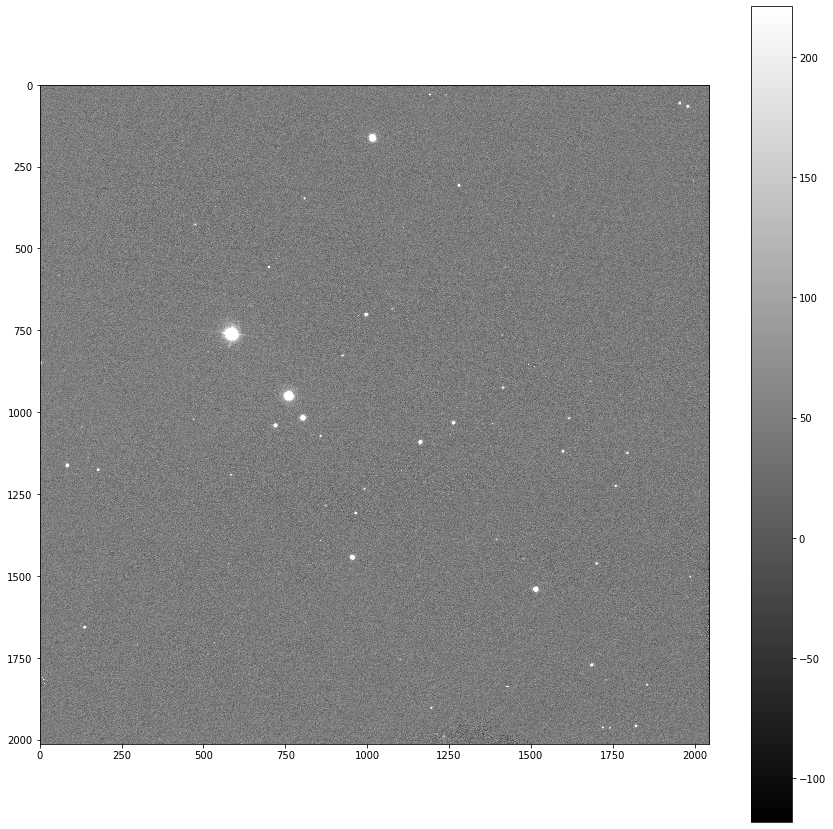

In [61]:
### Scaling Image to identify Objects ###

def show(im):
    plt.imshow(im, cmap='gray', vmin=image_data.mean()-0.2*image_data.std(), vmax=image_data.mean()+0.2*image_data.std())

plt.figure(figsize=(15, 15))
show(image_data)
plt.colorbar()

### Converting RA and DEC to Degrees

In [62]:
### Creating a Function to Convert Right Ascention(h : m : s) to Degrees ###

def RAtoDeg(ra):
    if ':' in ra:
        sep = ':'
        
    if ' ' in ra:
        sep = ' '
        
    if '-' in ra:
        sep = '-'
        
    h,m,s = ra.split(sep)
    h,m,s = float(h), float(m), float(s)
   
    
    deg = (h*15) + (m/4) + (s/240)
    print(deg)
    return deg

In [63]:
### Creating a Function to Convert Declination (deg : arc-min : arc-sec) to Degrees ###

def DECtoDeg(dec):
    if ':' in dec:
        sep = ':'
        
    if ' ' in dec:
        sep = ' '
    
    dem = dec[1:]
    if '-' in dem:
        sep = '-'
        
    d,d2,d3 = dec.split(sep)
    
    if d[0] == '-':
        d = float(d)
        d2 = float(d2)
        d3 = float(d3)

    
        deg = d - (d2/60) - (d3/3600)
    
 
    else:    
        d = float(d)
        d2 = float(d2)
        d3 = float(d3)

    
        deg = d + (d2/60) + (d3/3600)
    print(deg)
    return deg

In [64]:
### Converting Image RA and DEC to degrees ###
RA_deg = RAtoDeg(RA)
DEC_deg = DECtoDeg(DEC)

174.52704875
-18.90621583333333


## Step 2: Finding Known Stars in Image

--------------------------------------------------------------------------------------------

### Querying GAIA-ER3 Catalog for Know Stars

In [65]:
### Searching for Known Stars by Querying the GAIA EDR3 Star Catalog Using Location and Field Of View ###

import astropy.coordinates as coord
import astropy.units as u
from astropy.wcs import WCS
from astroquery.gaia import Gaia

Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"
Gaia.ROW_LIMIT = -1

coord = SkyCoord(ra=RA_deg, dec=DEC_deg, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(FOV, u.arcmin)
height = u.Quantity(FOV, u.arcmin)
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)

INFO: Query finished. [astroquery.utils.tap.core]


In [66]:
### Storing star Right Ascension, Declination and Magnitude into Variables.
rad = np.array(r['ra'])
ded = np.array(r['dec'])
rmag = np.array(r['phot_g_mean_mag'])

In [67]:
### Removing all known stars above Magnitude 20 ###
rad_f = rad  #[]
ded_f = ded  #[]
rmag_f = rmag  #[]
mag_max = 20
for i in range(len(rmag)):
    if rmag[i] < mag_max:
        rad_f.append(rad[i])
        ded_f.append(ded[i])
        rmag_f.append(rmag[i])

AttributeError: 'numpy.ndarray' object has no attribute 'append'

### Converting RA and DEC of Know Stars to Pixel Cordinates 

In [ ]:
#Converting RA and Dec Star Coordinates to Pixel Coordinates

x_y_cords = []
star_x = []
star_y = []

wcs = WCS(image1.header)

for ra1,dec1 in zip(rad_f,ded_f):
    
    c = SkyCoord(ra1, dec1, frame='icrs', unit='deg')
    print(c)
    x, y = wcs.world_to_pixel(c)
    
    star_x.append(x)
    star_y.append(y)
    x = 0
    y = 0

In [ ]:
#plot all pixel cordinates on top of image
plt.figure(figsize=(15, 15))

plt.imshow(image_data, cmap='gray', vmin=image_data.mean()-0.2*image_data.std(), vmax=image_data.mean()+0.2*image_data.std())
plt.scatter(star_x,star_y,10)

plt.show()

In [ ]:
### Using Weighted Mean to Calculate Accurate Centroiding of Each Detected Star ###

def find_complete_star(image,x,y):

    centroided_coords = []
    
    #print(y)
    background = np.mean(image_data)
    
    
    for b,a in zip(x,y):
        a = int(a)
        b = int(b)
        n = 12
        square = image[a-n:a+n, b-n:b+n]
        
        weighted_x = []
        weighted_y = []
        
        for xc in range(len(square)):
            for yc in range(len(square[xc])):
                weighted_x.append((square[xc,yc]**1)*(a+xc))
                weighted_y.append((square[xc,yc]**1)*(b+yc))
                
        x_centroid = np.sum(weighted_x)/np.sum(square**1)
        y_centroid = np.sum(weighted_y)/np.sum(square**1)
        
        #plt.imshow(square)
        #plt.scatter([y_centroid],[x_centroid])
       # plt.show()
        
        print(x_centroid-n, y_centroid-n)
        centroided_coords.append([y_centroid-n, x_centroid-n])
        
    return centroided_coords
        

In [ ]:
centroids = np.array(find_complete_star(image_data, star_x,star_y))

In [ ]:
#plot all pixel cordinates on top of image
plt.figure(figsize=(20, 20))

show(image_data)

#plt.scatter(star_x,star_y,5,color = 'b')
plt.scatter(centroids[:,0],centroids[:,1],5, color = 'r')

## Step 3: Eliminating all Know Stars From Image

---------------------------------

### Creating Circular Mask for any Radius length

In [ ]:
def area2radius(area):
    return round(((area/np.pi)**0.5)+5)

In [ ]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

### Creating Mask on every Star in Image

In [ ]:
IMAGE = image_data

In [ ]:
NEW_IMAGE = np.copy(image_data)
for coordinate in centroids:
    try:
        y, x = coordinate
        sub = IMAGE[int(x-20):int(x+20),int(y-20):int(y+20)]
        print(x,y)
        radius = (area2radius(np.sum(sub>100)))
        sample_mask = create_circular_mask(40,40, center = (20,20), radius=radius)
        mask = np.invert(create_circular_mask(IMAGE.shape[0],IMAGE.shape[1], center = (y,x), radius=radius))
        NEW_IMAGE*=mask
       
    except:
        continue

In [ ]:
plt.figure(figsize=(15,15))
show(NEW_IMAGE)

In [ ]:
def scale(im):
    VMIN = image_data.mean()-0.2*image_data.std()
    VMAX = image_data.mean()+0.2*image_data.std()
    
    # Mostly to clip hot pixels / extraneous values / noise
    # Sets pixels above VMAX to VMAX
    return np.clip(im, VMIN, VMAX)

In [ ]:
IMAGE_SCALED = scale(NEW_IMAGE)

In [ ]:
COORDINATES = []
STDS = []
MEANS = []
a = []
threshold = np.mean(IMAGE_SCALED) + (np.std(IMAGE_SCALED)*9)

print(threshold)

for y_p in tqdm(range(len(IMAGE_SCALED))[15:-15]):
    for x_p in range(len(IMAGE_SCALED[0]))[15:-15]:
        
        
        
        try:
            pixel_brightness = IMAGE_SCALED[x_p, y_p]
        except:
            continue
        a.append(pixel_brightness)
        if pixel_brightness > (threshold):
            
            
            mask_coordinates = []
            mask_coordinates2 = []
            
            for x_i in range(x_p-6, x_p+7):
                for y_i in range(y_p-6, y_p+7):
                    mask_coordinates.append([x_i, y_i])
                    
            for i in mask_coordinates:
                if len(i) > 1:
                    if int(i[0]) < int(NAXIS2) and int(i[1]) < int(NAXIS1):
                        mask_coordinates2.append(i)
                   
            mask_values = [IMAGE_SCALED[c[0], c[1]] for c in mask_coordinates2]
          
            STD = np.std(mask_values)
            MEAN = np.mean(mask_values)
            
            COORDINATES.append([x_p, y_p])
            STDS.append(STD)
            MEANS.append(MEAN)
            
COORDINATES = np.array(COORDINATES)
STDS = np.array(STDS)

In [ ]:
plt.plot(STDS)

In [ ]:
COORDINATES2 = COORDINATES[STDS>(np.mean(STDS))]
STDS2 = STDS[STDS>np.mean(STDS)]

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(IMAGE_SCALED, cmap='gray')
plt.scatter(COORDINATES2[:,1], COORDINATES2[:,0], s=80, facecolors='none', edgecolors='r')

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(COORDINATES2)

db = DBSCAN(eps=0.3, min_samples=1).fit(X)
LABELS = db.labels_

CENTROIDS = []
for cluster_n in range(LABELS.max()+1):
    
        CENTROIDS.append( np.mean(COORDINATES2[LABELS==cluster_n], axis=0) )

CENTROIDS = np.array(CENTROIDS)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(IMAGE_SCALED, cmap='gray')
plt.scatter(CENTROIDS[:,1], CENTROIDS[:,0], s=100, facecolors='none', edgecolors='r')

In [ ]:
FINAL_COORDINATES = []
for coordinate in CENTROIDS:
    try:
        x, y = coordinate
        sub = IMAGE_SCALED[int(x-15):int(x+15),int(y-15):int(y+15)]
        
        threshold = (np.mean(IMAGE_SCALED) + (np.std(IMAGE_SCALED)*4))
        num_brightpix = np.sum(sub>(threshold))
        #plt.imshow(sub)
        #plt.show()
        if num_brightpix>10:
            FINAL_COORDINATES.append((x,y))
       
    except:
        continue 
        
FINAL_COORDINATES = np.array(FINAL_COORDINATES)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(IMAGE_SCALED, cmap='gray')
plt.scatter(FINAL_COORDINATES[:,1], FINAL_COORDINATES[:,0], s=110, facecolors='none', edgecolors='r')

In [ ]:
STDS[0]

In [ ]:
import plotly.express as px
import pandas as pd


df = pd.DataFrame(dict(
    std = STDS,
    mean = MEANS
))
#df = df.sort_values(by="mean")

fig = px.line(df, y='std', title='Test')
fig.show()

In [ ]:
plt.figure(figsize=(15,15))

show(image_data)
plt.scatter(FINAL_COORDINATES[:,1], FINAL_COORDINATES[:,0], s=110, facecolors='none', edgecolors='r')

In [ ]:
import os # Help with file directories
mag_limit = 19
def known_asteroid_finder(date, time, fov1, fov2, mpc, ra, dec): #Date: year-month-day   Time: hh:mm:ss   FOV1: arcmin_start to end ra   FOV2: arcmin_start to end dec   MPC code: observatory minor planet center code

    sep = ''
    mpc_mod = sep.join("&mpc-code=" + mpc)
    date_mod = sep.join("&obs-time=" + date)
    time_mod = sep.join("_" + time)
    fov1_mod = sep.join("&fov-ra-center=" + ra)
    fov2_mod = sep.join("&fov-dec-center=" + dec)
    ra_mod = sep.join("&fov-ra-hwidth=" + fov2)
    dec_mod = sep.join("&fov-dec-hwidth=" + fov1)
    mag_mod = sep.join("&vmag-lim=" + str(mag_limit))
   
    start = 'https://ssd-api.jpl.nasa.gov/sb_ident.api?sb-kind=a&mag-required=true&two-pass=true&suppress-first-pass=true&req-elem=false'
    link = start, mpc_mod, date_mod, time_mod, fov1_mod, fov2_mod, ra_mod, dec_mod, mag_mod
    link = sep.join(link)
    return link

In [ ]:
def convert(ra,dec):
    if '+' in dec:
        dec = dec.replace("+", "")

  
    if ' ' in ra:
        ra1 = ra.split(' ')
        dec1 = dec.split(' ')
        sep = '-'
        
    if ':' in ra:
        ra1 = ra.split(':')
        dec1 = dec.split(':')
        sep = '-'
        
    ra = sep.join(ra1)
    dec = sep.join(dec1)
    return ra,dec

In [ ]:
ra, dec = convert(RA,DEC)

In [ ]:
date, time = DATE.split('T')
fov1 = str((FOV/60)/2)
fov2 = str((FOV2/60)/2)
mpc = 'E10'

In [ ]:
if '.' in time:
    time = time.split('.')
    time = time[0]

In [ ]:
time

In [ ]:
fov1

In [ ]:
ra,dec = convert(RA,DEC)

In [ ]:
asteroids = known_asteroid_finder(date, time, fov1, fov2, mpc, ra, dec)

In [ ]:
asteroids

In [ ]:
import requests
import json
response_API = requests.get(asteroids)
data = response_API.text

In [ ]:
data

In [ ]:
data = data.split('[')

In [ ]:
num = len(data) - 3

In [ ]:
num

In [ ]:
asteroids = []
for i in range(num):
    ast = data[i + 3]
    ast = ast.split(',')
    x,y = convert(ast[1],ast[2])
    print(x,y)
    asteroids.append([x,y])
    print(asteroids)

In [ ]:
asteroids

In [ ]:
known_asteroids_celestial = []
for a,b in asteroids:
    neg = 0
    x1 = []
    y1 = []
    for i in a:
        try:
            i = int(i)
            x1.append(str(i))
            
        except:
            pass
        
    x1.insert(2, ' ')
    x1.insert(5, ' ')
    if len(a)>8:
        x1.insert(8, '.')
    print(x1)
    x1 = ''.join(str(e) for e in x1)
    
    for i2 in b:
        if i2[0] == '-':
            neg = 1
        try:
            y1.append(int(i2))
        except:
            pass
    
    y1.insert(2, ' ')
    y1.insert(5, ' ')
    if len(b)>8:
        y1.insert(8, '.')
        
    if neg == 1:
        y1.insert(0, '-')
    
    y1 = ''.join(str(e) for e in y1)
    
    known_asteroids_celestial.append([x1,y1])

In [ ]:
a

In [ ]:
known_asteroids_celestial

In [ ]:
ra

In [ ]:
know_asteroids_ccd = []
for y,z in known_asteroids_celestial:
    
    know_asteroids_ccd.append([RAtoDeg(y), DECtoDeg(z)]) 
know_asteroids_ccd= np.array(know_asteroids_ccd)

In [ ]:
know_asteroids_ccd

In [ ]:
cords = []
for i in range(len(know_asteroids_ccd)):
   
    cords.append([know_asteroids_ccd[:,0][i], know_asteroids_ccd[:,1][i]])
    cord = np.array(cords)

In [ ]:
star_y

In [ ]:
x_y_cords = []
star_x = []
star_y = []

wcs = WCS(image1.header)

for ra1,dec1 in cords:
    
    c = SkyCoord(ra1, dec1, frame='icrs', unit='deg')
    print(c)
    x, y = wcs.world_to_pixel(c)
    
    star_x.append(x)
    star_y.append(y)
    x = 0
    y = 0

In [ ]:
# Commonly Used Functions for the Lab


# Function to read the FITS file

def read_file(filename, folder):

    
    #Join the filename to the folder path
    path = os.path.join(folder, filename)
    
    #Read the fits file
    hdulist = fits.open(path)
    
    #Extract relevant data products
    hdr, data = hdulist[0].header, hdulist[0].data
    
    center_of_field = [hdr['RA'], hdr['DEC']]
    
    #Display to user the observation date-time and location
    print("DATE AND TIME OF OBSERVATION: " + hdr['DATE-OBS'])
    
    print("APPROXIMATE CENTER OF THE OBSERVING FIELD (RA/DEC):", center_of_field)
    print()
    return hdr, data, center_of_field


# Function to search the USNO-B1 database for known stars in the field of view

def search_usno(ra_deg, dec_deg, fov_am):# RA/Dec in decimal degrees/J2000.0 FOV in arc min.

    #Request to open the USNO-B1 catalog from the internet
    str1 = 'http://webviz.u-strasbg.fr/viz-bin/asu-tsv/?-source=USNO-B1'
    str2 = '&-c.ra={:4.6f}&-c.dec={:4.6f}&-c.bm={:4.7f}/{:4.7f}&-out.max=unlimited'.format(ra_deg, dec_deg, fov_am, fov_am)
    f = url.request.urlopen(str1+str2)
    
    #   Read from the object, storing the page's contents in 's'.
    s = f.read()
    f.close()
    sl =s.splitlines()
    sl = sl[36:-1]    # get rid of header
    
    name = np.array([]) # Name of the Object
    rad = np.array([])  # RA in degrees
    ded = np.array([])  # DEC in degrees
    rmag = np.array([]) # Magnitude of the Object
    
    for k in sl:
        kw = k.decode().split('\t')
        try:
            float(kw[1])
        except:
            continue
        name = np.append(name,kw[0])
        rad = np.append(rad,float(kw[1]))
        ded = np.append(ded,float(kw[2]))
        if kw[12] != '     ': # deal with case where no mag is reported 
            rmag = np.append(rmag,float(kw[12])) 
        else:
            rmag = np.append(rmag,30.0) 
            
    return name, rad, ded, rmag

# Function to transform celestial coordinatoes of stars from USNO-B1 database to CCD pixel coordinates

def get_XY(alpha, delta, alpha0, delta0):

    #Convert all degree quantities to radians
    print(type(alpha))
    alpha = np.deg2rad(alpha)
    delta = np.deg2rad(delta)
    alpha0 = np.deg2rad(alpha0)
    delta0 = np.deg2rad(delta0)
    
    #Compute the projection relative to the center of the field
    X = np.cos(delta)*np.sin(alpha - alpha0)
    Y = np.sin(delta0)*np.cos(delta)*np.cos(alpha - alpha0) - np.cos(delta0)*np.sin(delta)
    norm = np.cos(delta0)*np.cos(delta)*np.cos(alpha - alpha0)+np.sin(delta0)*np.sin(delta)
    
    return X/norm, -1*Y/norm

# Function to help finding centroids of stars in the CCD Image

def approximate_transform(reference_stars, image_shape, focal_length, pixel_size, center_of_field, rotation_angle):

    #Intialize an array to hold to transformed co-ordinates
    transform_reference_stars = np.empty_like(reference_stars)

    #Convert data products to the required format for computation
    #alpha0, delta0 = convert2deg(*center_of_field)
    alpha0, delta0 = center_of_field
    rotation_angle = np.deg2rad(rotation_angle)
    
    #For each star
    for i in range(reference_stars.shape[0]):

        #Extract parameters
        star = reference_stars[i,:]
        alpha, delta = star[0], star[1]

        #Project onto a plane
        X, Y = get_XY(alpha, delta, alpha0, delta0)

        #Convert to approximate CCD pixel co-ordinates
        x = focal_length*(X/pixel_size) 
        y = focal_length*(Y/pixel_size) 

        #Apply a standard rotation
        x_rot = x*np.cos(rotation_angle) - y*np.sin(rotation_angle)
        y_rot = x*np.sin(rotation_angle) + y*np.cos(rotation_angle)

        #Center values on the CCD and add to the array of transformed co-ordinates
        transform_reference_stars[i,0] = x_rot + image_shape[1]/2.0 
        transform_reference_stars[i,1] = y_rot + image_shape[0]/2.0
        
    return transform_reference_stars



In [ ]:
plt.figure(figsize = (500,500))
asteroids1 = approximate_transform(cord, np.shape(image_data), Focal_Length, CCDXPIXE, (RA_deg, DEC_deg), 180)
plt.figure(figsize = (15,15))
plt.imshow(image_data, cmap = 'gray', vmin=image_data.mean() - 0.2*image_data.std(), vmax=image_data.mean() + 0.2*image_data.std())
plt.scatter(star_x, star_y, s = 105, facecolors='none', edgecolors='b')
plt.show()

In [ ]:
plt.figure(figsize=(15,15))

show(image_data)
plt.scatter(FINAL_COORDINATES[:,1], FINAL_COORDINATES[:,0], s=50, facecolors='none', edgecolors='r')
plt.scatter(star_x, star_y, s = 405, facecolors='none', edgecolors='b')


In [ ]:
FINAL_COORDINATES

In [ ]:
FINAL_COORDINATES2 = []
for a in zip(FINAL_COORDINATES[:,1], FINAL_COORDINATES[:,0]):

    for a1 in zip(star_x, star_y):
        print(abs(int(a[0])-int(a1[0])))
        if abs(int(a[0])-int(a1[0])) > 50 or (abs(int(a[1])-int(a1[1]))) > 50:
            print(1)
            FINAL_COORDINATES2.append([a[0], a[1]])
            

In [ ]:
for a in asteroids1[:,0], asteroids1[:,1]:
    print(a1)

In [ ]:
FINAL_COORDINATES2

In [ ]:
plt.figure(figsize=(15,15))

show(image_data)
plt.scatter(FINAL_COORDINATES2[0][0], FINAL_COORDINATES2[0][1], s=110, facecolors='none', edgecolors='r')